## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: [Mod4_Blog](https://renjmindy.github.io/diagnosis_of_covid-19_alike_viral_pneumonia)
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import itertools
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, plot_confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [2]:
new_dir = 'split/'

train_folder = os.path.join(new_dir, 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join(new_dir, 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join(new_dir, 'validation')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

## Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

In [4]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_folder, 
    # All images will be resized to 150x150
    target_size=(150, 150), batch_size = 10000)
    #, 
    # Since we use binary_crossentropy loss, we need binary labels
    #class_mode='binary')

training data:
Found 4685 images belonging to 2 classes.


In [5]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder, 
    target_size=(150, 150), batch_size = 2500)
    #,
    #class_mode='binary')

validating data:
Found 792 images belonging to 2 classes.


In [6]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder, 
    target_size=(150, 150), batch_size = 2500)
    #,
    #class_mode='binary') 

testing data:
Found 770 images belonging to 2 classes.


In [7]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [8]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(4685, 150, 150, 3)
(4685, 2)
(770, 150, 150, 3)
(770, 2)
(792, 150, 150, 3)
(792, 2)


In [9]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))

In [10]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [11]:
# Your code here; design and compile the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

In [13]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start = datetime.datetime.now()
print('program starts, current time:')
print(start)
#history = model.fit(train_images, train_y, epochs=40, batch_size=100, validation_data=(val_images, val_y))
history = model.fit(train_images, train_y, epochs=40, steps_per_epoch=100, 
                    validation_data=(val_images, val_y), validation_steps=50)
#history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data=val_generator, validation_steps=50)
end = datetime.datetime.now()
print('program ends, current time:')
print(end)
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

program starts, current time:
2020-11-21 05:37:20.490007
Epoch 1/40
100/100 [==============================] - 845s 8s/step - loss: 0.5748 - accuracy: 0.7291 - val_loss: 0.4938 - val_accuracy: 0.7790
Epoch 2/40
100/100 [==============================] - 730s 7s/step - loss: 0.5068 - accuracy: 0.7577 - val_loss: 0.4870 - val_accuracy: 0.7904
Epoch 3/40
100/100 [==============================] - 670s 7s/step - loss: 0.4545 - accuracy: 0.7878 - val_loss: 0.3560 - val_accuracy: 0.8788
Epoch 4/40
100/100 [==============================] - 603s 6s/step - loss: 0.4144 - accuracy: 0.7991 - val_loss: 0.3395 - val_accuracy: 0.8460
Epoch 5/40
100/100 [==============================] - 601s 6s/step - loss: 0.3770 - accuracy: 0.8352 - val_loss: 0.3155 - val_accuracy: 0.8750
Epoch 6/40
100/100 [==============================] - 616s 6s/step - loss: 0.3525 - accuracy: 0.8408 - val_loss: 0.2980 - val_accuracy: 0.8876
Epoch 7/40
100/100 [==============================] - 602s 6s/step - loss: 0.3273 - a

## CNN Model Evaluation

Now use the test set to perform an evaluation on the model of choice. 

In [14]:
results_train = model.evaluate(train_images, train_y)

147/147 [==============================] - 83s 567ms/step - loss: 0.1150 - accuracy: 0.9530


In [15]:
results_test = model.evaluate(test_images, test_y)

25/25 [==============================] - 15s 605ms/step - loss: 0.5004 - accuracy: 0.8753


In [16]:
results_train

[0.11502913385629654, 0.9530416131019592]

In [17]:
results_test

[0.5003767013549805, 0.8753246665000916]

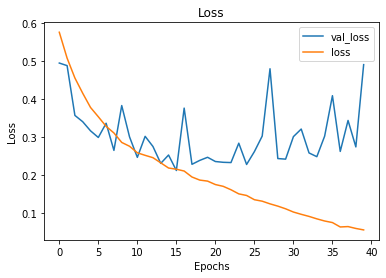

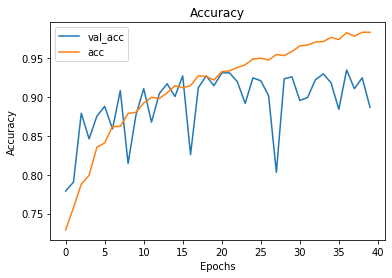

In [18]:
visualize_training_results(history)

## Saving CNN Model

In [19]:
# Your code here; save the model for future reference 
model.save('cnn1_chest_xray_data_augmentation_'+str(date.today())+'.h5')

In [20]:
preds_model = model.predict(test_images)

In [21]:
type(preds_model)

numpy.ndarray

In [22]:
preds_model.shape

(770, 1)

In [23]:
test_y.shape

(770, 1)

In [24]:
pred_model_class = model.predict_classes(test_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [25]:
pred_model_class.shape

(770, 1)

In [26]:
pred_model_binary_class = (model.predict(test_images) > 0.5).astype("int32")
pred_model_binary_class.shape

(770, 1)

In [27]:
accuracy_model = accuracy_score(test_y, preds_model.round())
accuracy_model

0.8753246753246753

In [28]:
precision_model = precision_score(test_y, preds_model.round())
precision_model

0.6833333333333333

In [29]:
recall_model = recall_score(test_y, preds_model.round())
recall_model

0.9951456310679612

In [30]:
f1_model = f1_score(test_y, preds_model.round())
f1_model

0.8102766798418972

In [31]:
auc_value_model = roc_auc_score(test_y, preds_model)
auc_value_model

0.9881351993389796

In [32]:
# test set
true_classes_vgg19 = test_generator.classes
print(true_classes_vgg19)
class_labels_vgg19 = list(test_generator.class_indices.keys())
class_labels_vgg19

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [33]:
fpr_model, tpr_model, threshold_model = roc_curve(test_y, preds_model)

In [34]:
roc_auc_model = auc(fpr_model, tpr_model)

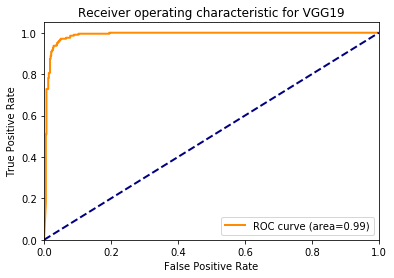

In [35]:
plt.figure()
lw=2
plt.plot(fpr_model, tpr_model, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_model)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for VGG19')
plt.legend(loc='lower right')
plt.show()

In [36]:
report_model = classification_report(test_y, preds_model.round())
print(report_model)

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91       564
         1.0       0.68      1.00      0.81       206

    accuracy                           0.88       770
   macro avg       0.84      0.91      0.86       770
weighted avg       0.91      0.88      0.88       770



In [37]:
cnf_matrix_model = confusion_matrix(y_true=test_y, y_pred=preds_model.round())
np.set_printoptions(precision=2)
print(cnf_matrix_model)

[[469  95]
 [  1 205]]


In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
cm_plot_labels = ['NORMAL','PNEUMONIA']

Confusion matrix, without normalization
[[469  95]
 [  1 205]]


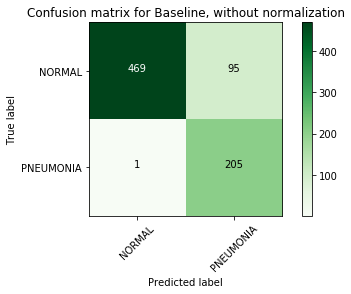

In [40]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model, classes=cm_plot_labels, title='Confusion matrix for Baseline, without normalization')
plt.show()

Normalized confusion matrix
[[0.83 0.17]
 [0.   1.  ]]


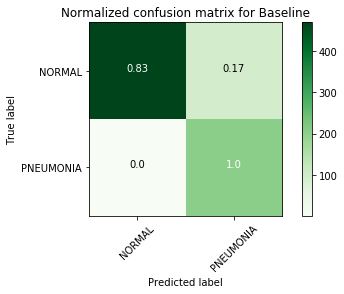

In [41]:
plt.figure()
plot_confusion_matrix(cnf_matrix_model, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

## Saving history in CSV

In [42]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
# or save to csv: 
hist_csv_file = 'cnn1_chest_xray_data_augmentation'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Learning rate tuning (hyper-parameter tuning)

In [43]:
# Your code here; design and compile the model
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [44]:
model2.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [45]:
# Set the model to train 
# ⏰ This cell may take several hours to run 
start2 = datetime.datetime.now()
print('program starts, current time:')
print(start2)
#history2 = model2.fit(train_images, train_y, epochs=100, batch_size=100, validation_data=(val_images, val_y))
history2 = model2.fit(train_images, train_y, epochs=40, steps_per_epoch=100, 
                      validation_data=(val_images, val_y), validation_steps=50)
end2 = datetime.datetime.now()
print('program ends, current time:')
print(end2)
elapsed2 = end2 - start2
print('Training took a total of {}'.format(elapsed2))

program starts, current time:
2020-11-21 17:38:45.176506
Epoch 1/40
100/100 [==============================] - 436s 4s/step - loss: 0.5855 - accuracy: 0.7296 - val_loss: 0.5717 - val_accuracy: 0.7134
Epoch 2/40
100/100 [==============================] - 693s 7s/step - loss: 0.5417 - accuracy: 0.7321 - val_loss: 0.5043 - val_accuracy: 0.7563
Epoch 3/40
100/100 [==============================] - 763s 8s/step - loss: 0.4952 - accuracy: 0.7550 - val_loss: 0.4589 - val_accuracy: 0.7487
Epoch 4/40
100/100 [==============================] - 827s 8s/step - loss: 0.4584 - accuracy: 0.7808 - val_loss: 0.4081 - val_accuracy: 0.7904
Epoch 5/40
100/100 [==============================] - 832s 8s/step - loss: 0.4406 - accuracy: 0.7912 - val_loss: 0.3913 - val_accuracy: 0.7955
Epoch 6/40
100/100 [==============================] - 693s 7s/step - loss: 0.4224 - accuracy: 0.7994 - val_loss: 0.3776 - val_accuracy: 0.8598
Epoch 7/40
100/100 [==============================] - 679s 7s/step - loss: 0.4063 - a

In [46]:
results2_train = model2.evaluate(train_images, train_y)

147/147 [==============================] - 83s 566ms/step - loss: 0.2731 - accuracy: 0.8751


In [47]:
results2_test = model.evaluate(test_images, test_y)

25/25 [==============================] - 15s 610ms/step - loss: 0.5004 - accuracy: 0.8753


In [48]:
results2_train

[0.27313166856765747, 0.8751333951950073]

In [49]:
results2_test

[0.5003767013549805, 0.8753246665000916]

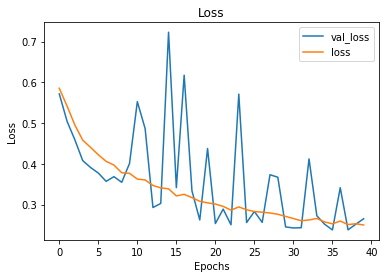

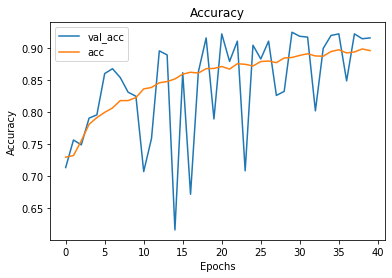

In [50]:
visualize_training_results(history2)

In [51]:
# Your code here; save the model for future reference 
model2.save('cnn1_chest_xray_data_augmentation_LearningRate_Tuning_'+str(date.today())+'.h5')

In [52]:
preds_cnn2 = model2.predict(test_images)

In [53]:
type(preds_cnn2)

numpy.ndarray

In [54]:
preds_cnn2.shape

(770, 1)

In [55]:
pred_cnn2_class = model2.predict_classes(test_images)

In [56]:
pred_cnn2_class.shape

(770, 1)

In [57]:
pred_cnn2_binary_class = (model2.predict(test_images) > 0.5).astype("int32")
pred_cnn2_binary_class.shape

(770, 1)

In [58]:
# test set
true_classes_cnn2 = test_generator.classes
print(true_classes_cnn2)
class_labels_cnn2 = list(test_generator.class_indices.keys())
class_labels_cnn2

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

['NORMAL', 'PNEUMONIA']

In [59]:
accuracy_cnn2 = accuracy_score(test_y, preds_cnn2.round())
accuracy_cnn2

0.9467532467532468

In [60]:
precision_cnn2 = precision_score(test_y, preds_cnn2.round())
precision_cnn2

0.9411764705882353

In [61]:
recall_cnn2 = recall_score(test_y, preds_cnn2.round())
recall_cnn2

0.8543689320388349

In [62]:
f1_cnn2 = f1_score(test_y, preds_cnn2.round())
f1_cnn2

0.8956743002544529

In [63]:
auc_value_cnn2 = roc_auc_score(test_y, preds_cnn2)
auc_value_cnn2

0.9835691661502444

In [64]:
fpr_cnn2, tpr_cnn2, threshold_cnn2 = roc_curve(test_y, preds_cnn2)

In [65]:
roc_auc_cnn2 = auc(fpr_cnn2, tpr_cnn2)

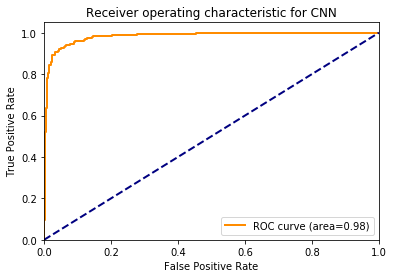

In [66]:
plt.figure()
lw=2
plt.plot(fpr_cnn2, tpr_cnn2, color='darkorange', lw=lw, label='ROC curve (area=%.2f)' %auc_value_cnn2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for CNN')
plt.legend(loc='lower right')
plt.show()

In [67]:
report_cnn2 = classification_report(test_y, preds_cnn2.round(), target_names=class_labels_cnn2)
print(report_cnn2)

              precision    recall  f1-score   support

      NORMAL       0.95      0.98      0.96       564
   PNEUMONIA       0.94      0.85      0.90       206

    accuracy                           0.95       770
   macro avg       0.94      0.92      0.93       770
weighted avg       0.95      0.95      0.95       770



In [68]:
cnf_matrix_cnn2 = confusion_matrix(y_true=test_y, y_pred=preds_cnn2.round())
np.set_printoptions(precision=2)
print(cnf_matrix_cnn2)

[[553  11]
 [ 30 176]]


Confusion matrix, without normalization
[[553  11]
 [ 30 176]]


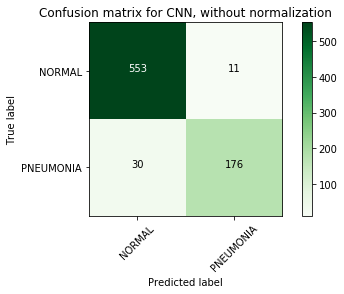

In [69]:
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn2, classes=cm_plot_labels, title='Confusion matrix for CNN, without normalization')
plt.show()

Normalized confusion matrix
[[0.98 0.02]
 [0.15 0.85]]


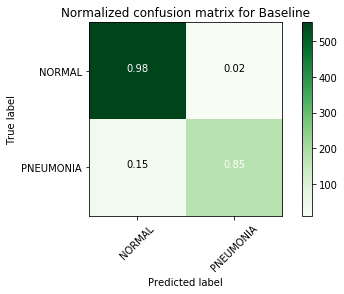

In [70]:
plt.figure()
plot_confusion_matrix(cnf_matrix_cnn2, classes=cm_plot_labels, normalize=True, title='Normalized confusion matrix for Baseline')
plt.show()

In [71]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history2.history) 
# or save to csv: 
hist_csv_file = 'cnn1_chest_xray_data_augmentation_LearningRate_Tuning'+str(date.today())+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)